In [1]:
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio

from pathlib import Path
import pandas as pd

import statsmodels.api as sm
import scipy.stats as stats

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

In [2]:
pio.renderers.default = "iframe"

In [3]:
# base_path = "/data/saturation/random_runs_large_bungled"
# base_path = "/data/saturation/random_runs_large"
# base_path = "/data/saturation/r_stat_changes_messy"
# base_path = "/data/saturation/r_stat_changes"
# base_path = "/data/saturation/r_stat_changes_smaller_min"
# base_path = "/data/saturation/central_composite_design/ccd3"
base_path = "/data/saturation/central_composite_design/ccd5"
ivs = ["slope", "effective_radius_multiplier", "r_stat_multiplier", "min_rim_percentage"]

In [ ]:
stats_df = pd.read_csv(f"{base_path}/post_saturation_statistics_corners.csv")
# stats_df = pd.read_csv(f"{base_path}/post_saturation_statistics_interior.csv")
stats_df.head()

In [ ]:
plt.scatter(stats_df.n_craters_at_completion, stats_df.run_duration_seconds)

### Visualizing 99th percentile post-saturation areal density

Notes on simulation parameters:
- Slope:
    - Controls the SFD of new craters. Larger slope -> more smaller craters
- R_stat multiplier:
    - Affects the minimum crater size for statistics collection: R_stat = R_stat multiplier * R_min
    - Range ~ 3-9
    - Affects how large a new crater must be to affect an existing crater. R_existing / R_new < R_stat multiplier
        - Larger R_stat multiplier -> more crater destruction
- Min rim percentage:
    - Controls how much of a crater's rim must be intact to remain in the record.
    - Larger min rim percentage -> more crater destruction
- Effective radius mutiplier:
    - Represents the effect of ejecta
    - Multiplies the radius of a new crater for the purposes of destroying existing craters' rims
    - Larger effective radius multiplier -> more crater destruction
    
Generally - the more crater destruction, the lower the areal density at saturation.



Questions for Dr. Kirchoff:
- Is it reasonable to fix the minimum crater size for statistics (R_stat), and allow R_min to vary instead?
- What are reasonable ranges for these four parameters?
- May we assume researchers can specify a reasonable range for all four of these parameters for a given terrain?



To do:
- Review Squyres' explanation of R_stat
- Normalize parameters' scales
- Indicators on plots for higher destruction direction?
- Look into effect sizes for linear models
- If we build models using Za, AD, etc, when do they match?
- Request a meeting with Dr. Kirchoff

In [ ]:
metric = "areal_density_median"

In [ ]:
# Normalize for coloring plot markers
stats_df["marker_size"] = 1
hover_data = {
    "slope": ":.3f",
    "effective_radius_multiplier": ":.3f",
    "r_stat_multiplier": ":.3f",
    "min_rim_percentage": ":.3f",
    metric : ":.3f"
}
fig = px.scatter_matrix(
    stats_df,
    dimensions=ivs,
    hover_data=hover_data,
    color=metric,
    size="marker_size",
    size_max=5,
    width=1200,
    height=800
)
fig.show()

In [ ]:
# Destructive parameters
fig = px.scatter_3d(
    stats_df,
    x="min_rim_percentage",
    y="effective_radius_multiplier",
    z="r_stat_multiplier",
    color=metric,
    size="marker_size",
    size_max=10,
    hover_data=hover_data,
    width=1000,
    height=1000
)
fig.show()

In [ ]:
fig = px.scatter_3d(
    stats_df,
    x="slope",
    y="effective_radius_multiplier",
    z="r_stat_multiplier",
    color=metric,
    size="marker_size",
    size_max=10,
    hover_data=hover_data,
    width=1000,
    height=1000
)
fig.show()

In [ ]:
fig = px.scatter_3d(
    stats_df,
    x="slope",
    y="min_rim_percentage",
    z="r_stat_multiplier",
    color=metric,
    size="marker_size",
    size_max=10,
    hover_data=hover_data,
    width=1000,
    height=1000
)
fig.show()

In [ ]:
fig = px.scatter_3d(
    stats_df,
    x="slope",
    y="effective_radius_multiplier",
    z="min_rim_percentage",
    color=metric,
    size="marker_size",
    size_max=10,
    hover_data=hover_data,
    width=1000,
    height=1000
)
fig.show()

### Linear regression model

In [ ]:
def fit_and_report_model(model, data, dependent_variable, model_name):
    # X = data[["slope", "effective_radius_multiplier", "r_stat_multiplier", "min_rim_percentage"]].copy()
    X = data.drop([dependent_variable], axis=1)
    y = data[dependent_variable]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    model_fit = model.fit(X_train, y_train)
    
    y_pred = model.predict(X_train)
    rmse = mean_squared_error(y_pred, y_train, squared=False)
    mape = mean_absolute_percentage_error(y_pred, y_train)
    print(f"{model_name}: Train RMSE: {rmse:.4f}, Train MAPE: {mape:.4f}")
    
    residuals = y_train - y_pred
    plt.hist(residuals)
    
    ks_norm_p = stats.kstest(residuals, cdf=stats.norm.cdf).pvalue
    ad_result = stats.anderson(residuals, dist="norm")
    print(f"KS test p-value on training residuals: {ks_norm_p:.3f}")
    print(f"AD test on training residuals: {ad_result.statistic:.3f}, critical values: {ad_result.critical_values}, significance levels: {ad_result.significance_level}")
    
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_pred, y_test, squared=False)
    mape = mean_absolute_percentage_error(y_pred, y_test)
    print(f"{model_name}: Test RMSE: {rmse:.4f}, Test MAPE: {mape:.4f}")
    
    y_pred_mean_model = [y_train.mean()] * len(y_test)
    rmse = mean_squared_error(y_pred_mean_model, y_test, squared=False)
    mape = mean_absolute_percentage_error(y_pred_mean_model, y_test)
    print(f"Mean model: RMSE: {rmse:.4f}, MAPE: {mape:.4f}")
    
    return model_fit

#### Checking scatterplots

In [ ]:
metric = "areal_density_median"
series = stats_df[metric]

for iv in ivs:
    plt.scatter(stats_df[iv], series, s=1)
    plt.xlabel(iv)
    plt.ylabel(metric)
    plt.show()

In [ ]:
metric = "areal_density_99_percentile"
series = stats_df[metric]

for iv in ivs:
    plt.scatter(stats_df[iv], series, s=1)
    plt.xlabel(iv)
    plt.ylabel(metric)
    plt.show()

AD_max = f(slope, min_rim, eff_rad, r_stat_mult)
f(slope=1.8-2.0, min_rim=.4-.45, ....)
AD_max in (0.4, 0.6)

In [ ]:
# Fit using sklearn
model = LinearRegression(fit_intercept=True)
model = fit_and_report_model(model, stats_df[ivs + [metric]], metric, "lm")

In [ ]:
poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=2)
X = poly_transform.fit_transform(stats_df[ivs])
X = pd.DataFrame(X, columns=poly_transform.get_feature_names_out())
X[metric] = stats_df[metric]

In [ ]:
# Fit using sklearn
model = LinearRegression(fit_intercept=True)
model = fit_and_report_model(model, X, metric, "lm")

In [ ]:
exclude = {
    metric,
    "r_stat_multiplier",
    "slope effective_radius_multiplier",
    "effective_radius_multiplier r_stat_multiplier",
    "slope r_stat_multiplier",
    "min_rim_percentage^2",
    "r_stat_multiplier min_rim_percentage",
    "r_stat_multiplier^2"
}
model = sm.OLS(stats_df[metric], sm.add_constant(X[[x for x in X.columns if x not in exclude]]))
result = model.fit()
result.summary()

In [ ]:
# Fit using sklearn
model = LinearRegression(fit_intercept=True)
model = fit_and_report_model(model, stats_df[[
    #"slope_effective_radius_multiplier",
                                                           "slope_r_stat_multiplier",
                                                           #"slope_min_rim_percentage",
                                                           #"r_stat_multiplier_effective_radius_multiplier", 
                                                           #"r_stat_multiplier_min_rim_percentage",
                                                           "effective_radius_multiplier_min_rim_percentage",
                                                           "slope_effective_radius_multiplier_min_rim_percentage",
                                                           "slope",
                                                           "effective_radius_multiplier",
                                                           "r_stat_multiplier",
                                                           "min_rim_percentage", metric]], metric, "lm")

In [ ]:
# Fit using statsmodels for p-values
stats_df["slope_effective_radius_multiplier"] = stats_df.slope * stats_df.effective_radius_multiplier
stats_df["slope_r_stat_multiplier"] = stats_df.slope * stats_df.r_stat_multiplier
stats_df["slope_min_rim_percentage"] = stats_df.slope * stats_df.min_rim_percentage
stats_df["r_stat_multiplier_effective_radius_multiplier"] = stats_df.r_stat_multiplier * stats_df.effective_radius_multiplier
stats_df["r_stat_multiplier_min_rim_percentage"] = stats_df.r_stat_multiplier * stats_df.min_rim_percentage
stats_df["effective_radius_multiplier_min_rim_percentage"] = stats_df.min_rim_percentage * stats_df.effective_radius_multiplier
stats_df["slope_effective_radius_multiplier_min_rim_percentage"] = stats_df.slope * stats_df.min_rim_percentage * stats_df.effective_radius_multiplier
stats_df["slope_effective_radius_multiplier_squared"] = stats_df.effective_radius_multiplier * stats_df.effective_radius_multiplier

model = sm.OLS(stats_df[metric], sm.add_constant(stats_df[[
    #"slope_effective_radius_multiplier",
                                                           "slope_r_stat_multiplier",
                                                           "slope_effective_radius_multiplier_squared",
                                                           #"slope_min_rim_percentage",
                                                           #"r_stat_multiplier_effective_radius_multiplier", 
                                                           #"r_stat_multiplier_min_rim_percentage",
                                                           "effective_radius_multiplier_min_rim_percentage",
                                                           "slope_effective_radius_multiplier_min_rim_percentage",
                                                           "slope",
                                                           "effective_radius_multiplier",
                                                           "r_stat_multiplier",
                                                           "min_rim_percentage"]]))
result = model.fit()
result.summary()

In [ ]:
model = sm.OLS(stats_df[metric], sm.add_constant(stats_df[ivs]))
result = model.fit()
result.summary()

In [ ]:
model = sm.OLS(stats_df[metric], sm.add_constant(stats_df[[
    # "slope_effective_radius_multiplier",
                                                           # "slope_r_stat_multiplier",
                                                           "slope_effective_radius_multiplier_squared",
                                                           # "slope_min_rim_percentage",
                                                           "r_stat_multiplier_effective_radius_multiplier", 
                                                           # "r_stat_multiplier_min_rim_percentage",
                                                           "effective_radius_multiplier_min_rim_percentage",
                                                           "slope_effective_radius_multiplier_min_rim_percentage",
                                                           "slope",
                                                           "effective_radius_multiplier",
                                                           "r_stat_multiplier",
                                                           "min_rim_percentage"]]))
result = model.fit()
result.summary()

In [ ]:
# Fit using statsmodels for p-values
stats_df["slope_effective_radius_multiplier"] = stats_df.slope * stats_df.effective_radius_multiplier
stats_df["slope_r_stat_multiplier"] = stats_df.slope * stats_df.r_stat_multiplier
stats_df["slope_min_rim_percentage"] = stats_df.slope * stats_df.min_rim_percentage
stats_df["r_stat_multiplier_effective_radius_multiplier"] = stats_df.r_stat_multiplier * stats_df.effective_radius_multiplier
stats_df["r_stat_multiplier_min_rim_percentage"] = stats_df.r_stat_multiplier * stats_df.min_rim_percentage
stats_df["effective_radius_multiplier_min_rim_percentage"] = stats_df.min_rim_percentage * stats_df.effective_radius_multiplier
stats_df["slope_effective_radius_multiplier_min_rim_percentage"] = stats_df.slope * stats_df.min_rim_percentage * stats_df.effective_radius_multiplier

model = sm.OLS(stats_df[metric], sm.add_constant(stats_df[[
    # "slope_effective_radius_multiplier",
                                                           "slope_r_stat_multiplier",
                                                           # "slope_min_rim_percentage",
                                                           # "r_stat_multiplier_effective_radius_multiplier", 
                                                           # "r_stat_multiplier_min_rim_percentage",
                                                           "effective_radius_multiplier_min_rim_percentage",
                                                           "slope_effective_radius_multiplier_min_rim_percentage",
                                                           "slope",
                                                           "effective_radius_multiplier",
                                                           "r_stat_multiplier",
                                                           "min_rim_percentage"]]))
result = model.fit()
result.summary()

### Random forest model

In [ ]:
max_depth = 5
n_estimators = 5000

model = RandomForestRegressor(max_depth=max_depth,
                              n_estimators=n_estimators,
                              random_state=42)
model_fit = fit_and_report_model(model, stats_df, metric, f"RF({max_depth}, {n_estimators})")

### Gradient boosted trees model

In [ ]:
max_depth = 3
n_estimators = 500

model = GradientBoostingRegressor(max_depth=max_depth,
                                  n_estimators=n_estimators,
                                  random_state=42)
model_fit = fit_and_report_model(model, stats_df, metric, f"GBT({max_depth}, {n_estimators})")

### Plotting a single simulation's statistics

In [ ]:
def read_stats_parquets(path: str) -> pd.DataFrame:
    # Read all statistics parquet files
    filenames = Path(path).glob("statistics*.parquet")
    dataframes = []
    for filename in filenames:
        df = pd.read_parquet(filename)
        dataframes.append(df)
    df = pd.concat(dataframes)
    df = df.sort_values(by=["crater_id"]).reset_index(drop=True)
    
    return df

def get_path(slope: float,
             effective_radius_multiplier: float,
             r_stat_multiplier: float,
             min_rim_percentage: float,
             base_path: str,
             prefix: str = "interior_point") -> pd.DataFrame:
    return f"{base_path}/{prefix}_{effective_radius_multiplier:.3f}_{min_rim_percentage:.3f}_{r_stat_multiplier:.3f}_{slope:.3f}/1/"


In [ ]:
paths = list(Path(base_path).glob("corner*/1/"))

for path in paths[-3:]:
    df = read_stats_parquets(path)
    plt.plot(df.n_craters_added_in_study_region, df.areal_density)
    plt.title(path)
    plt.show()

In [ ]:
# # Finding saturation points
# for path in paths[:]:
#     df = read_stats_parquets(path)
#     n_sims = df.shape[0]
#     checkpoint = n_sims // 3 * 2
#     checkpoint_max_ad = df.areal_density[:checkpoint].max()
#     checkpoint_max_n = df.n_craters_in_study_region[:checkpoint].max()
#     max_index = max(df.areal_density.idxmax(), df.n_craters_in_study_region.idxmax())
#     print(f"{path}, {max_index / df.shape[0]:.3f}")
#     # print(f"{path}, {max_index}, {df.shape[0]}, {checkpoint_max_ad:.3f}, {df.areal_density.max():.3f}, {checkpoint_max_n}, {df.n_craters_in_study_region.max()}")

In [ ]:
# all_ads = []
# for path in paths:
#     df = read_stats_parquets(path)
#     max_index = df.areal_density.idxmax()
#     df_sat = df.iloc[max_index:]
#     print(f"{path}, {df_sat.areal_density.median()}, {df_sat.areal_density.std()}, {len(df_sat)}, {max_index}")
#     # plt.hist(df_sat.areal_density)
#     # plt.show()
#     all_ads += list(df_sat.areal_density)

In [ ]:
all_ads = []
for path in paths[:5]:
    df = read_stats_parquets(path)
    max_index = df.areal_density.idxmax()
    df_sat = df.iloc[-200000:]
    print(f"{df_sat.areal_density.median()}, {df_sat.areal_density.std()}")
    # plt.hist(df_sat.areal_density)
    # plt.show()
    all_ads += list(df_sat.areal_density)

In [ ]:
plt.hist(all_ads)

In [ ]:
max_index = df.areal_density.idxmax()
df_sat = df.iloc[max_index:]
plt.plot(df_sat.n_craters_added_in_study_region, df_sat.areal_density)
plt.show()
plt.hist(df_sat.areal_density)
plt.show()

In [ ]:
# Modeling areal density using post-saturation sample

In [4]:
def fit_and_report_model(model, data, dependent_variable, model_name):
    X = data.drop([dependent_variable], axis=1)
    y = data[dependent_variable]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    model_fit = model.fit(X_train, y_train)
    
    y_pred = model.predict(X_train)
    rmse = mean_squared_error(y_pred, y_train, squared=False)
    mape = mean_absolute_percentage_error(y_pred, y_train)
    print(f"{model_name}: Train RMSE: {rmse:.4f}, Train MAPE: {mape:.4f}")
    
    residuals = y_train - y_pred
    plt.hist(residuals)
    
    ks_norm_p = stats.kstest(residuals, cdf=stats.norm.cdf).pvalue
    ad_result = stats.anderson(residuals, dist="norm")
    print(f"KS test p-value on training residuals: {ks_norm_p:.3f}")
    print(f"AD test on training residuals: {ad_result.statistic:.3f}, critical values: {ad_result.critical_values}, significance levels: {ad_result.significance_level}")
    
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_pred, y_test, squared=False)
    mape = mean_absolute_percentage_error(y_pred, y_test)
    print(f"{model_name}: Test RMSE: {rmse:.4f}, Test MAPE: {mape:.4f}")
    
    y_pred_mean_model = [y_train.mean()] * len(y_test)
    rmse = mean_squared_error(y_pred_mean_model, y_test, squared=False)
    mape = mean_absolute_percentage_error(y_pred_mean_model, y_test)
    print(f"Mean model: RMSE: {rmse:.4f}, MAPE: {mape:.4f}")
    
    return model_fit

In [5]:
stats_df = pd.read_csv(f"{base_path}/post_saturation_sample_5000.csv")
stats_df.head()

,simulation_id,slope,r_stat_multiplier,effective_radius_multiplier,min_rim_percentage,crater_id,n_craters_added_in_study_region,n_craters_in_study_region,areal_density,z,za
0,26,1.113464,3.024217,1.899068,0.700091,2686130,499998,426,0.224960,-5.387406,-0.753683
1,26,1.113464,3.024217,1.899068,0.700091,2686097,499991,421,0.224657,-5.411498,-0.820158
2,26,1.113464,3.024217,1.899068,0.700091,2686043,499984,414,0.224270,-5.336032,-0.788430
3,26,1.113464,3.024217,1.899068,0.700091,2686002,499975,427,0.220655,-5.433428,-0.906793
4,26,1.113464,3.024217,1.899068,0.700091,2685887,499954,406,0.219667,-5.788088,-1.462709


In [ ]:
# Some plots

In [7]:
metric = "areal_density"

In [ ]:
plt.hist(stats_df.areal_density)

In [ ]:
plt.hist(stats_df.z)

In [ ]:
plt.hist(stats_df.za)

In [8]:
poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=2)
X = poly_transform.fit_transform(stats_df[ivs])
X = pd.DataFrame(X, columns=poly_transform.get_feature_names_out())
X[metric] = stats_df[metric]

lm: Train RMSE: 0.0376, Train MAPE: 0.0739
KS test p-value on training residuals: 0.000
AD test on training residuals: 27342.366, critical values: [0.576 0.656 0.787 0.918 1.092], significance levels: [15.  10.   5.   2.5  1. ]
lm: Test RMSE: 0.0377, Test MAPE: 0.0740
Mean model: RMSE: 0.1751, MAPE: 0.3686


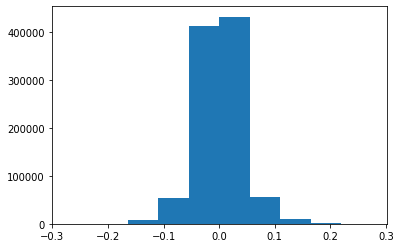

In [9]:
# Fit using sklearn
model = LinearRegression(fit_intercept=True)
model = fit_and_report_model(model, X, metric, "lm")

lm: Train RMSE: 0.0368, Train MAPE: 0.0705
KS test p-value on training residuals: 0.000
AD test on training residuals: 33572.410, critical values: [0.576 0.656 0.787 0.918 1.092], significance levels: [15.  10.   5.   2.5  1. ]
lm: Test RMSE: 0.0369, Test MAPE: 0.0707
Mean model: RMSE: 0.1751, MAPE: 0.3686


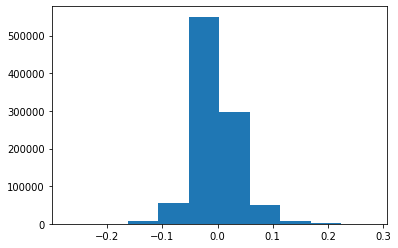

In [10]:
# Fit using sklearn
model = RandomForestRegressor(max_depth=5,
                              n_estimators=500,
                              n_jobs=25,
                              random_state=42)
model = fit_and_report_model(model, X, metric, "lm")

lm: Train RMSE: 0.0363, Train MAPE: 0.0679
KS test p-value on training residuals: 0.000
AD test on training residuals: 39344.945, critical values: [0.576 0.656 0.787 0.918 1.092], significance levels: [15.  10.   5.   2.5  1. ]
lm: Test RMSE: 0.0364, Test MAPE: 0.0681
Mean model: RMSE: 0.1751, MAPE: 0.3686


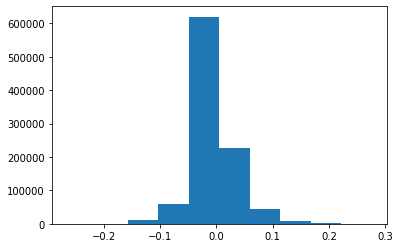

In [11]:
# Fit using sklearn
model = GradientBoostingRegressor(max_depth=5,
                              n_estimators=1000,
                              random_state=42)
model = fit_and_report_model(model, X, metric, "lm")

In [ ]:
metric = "areal_density"
ivs = ["slope", "r_stat_multiplier", "effective_radius_multiplier", "min_rim_percentage", "n_craters_in_study_region"]

In [ ]:
poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=2)
X = poly_transform.fit_transform(stats_df[ivs])
X = pd.DataFrame(X, columns=poly_transform.get_feature_names_out())

In [ ]:
X[x for x in X.columns if x not in exclude]

In [ ]:
exclude = {
    "r_stat_multiplier^2",
    "slope n_craters_in_study_region",
    "slope r_stat_multiplier"
}
model = sm.OLS(stats_df[metric], sm.add_constant(X[[x for x in X.columns if x not in exclude]]))
result = model.fit()
result.summary()

In [ ]:
plt.hist(result.resid)

In [ ]:
resid_df = stats_df[[metric] + ivs].copy()
resid_df["residual"] = result.resid

In [ ]:
resid_df

In [ ]:
import sklearn

In [ ]:
model = sklearn.linear_model.LinearRegression().fit(stats_df[["areal_density", "z", "za"]], stats_df[ivs])

In [ ]:
model.coef_

In [ ]:
model.